# Nutrition Health Survey- Age Prediction
### Hackathon: 2 - Summer Analytics 2025, IIT Guwahati
* NIDHISH VANDEKAR 
* v.nidhish@iitg.ac.in

### About Hackathon
The National Health and Nutrition Examination Survey (NHANES) is a nationally representative health study conducted by the CDC’s National Center for Health Statistics. It uniquely combines interviews, physical exams, and lab tests to assess the health and nutritional status of U.S. children and adults. 
This dataset is a subset, focused part of the NHANES study by CDC, which looks at health and nutrition trends in the U.S. It has 6,287 entries and 7 key features: covering things like body stats, lifestyle, and lab results. The task is simple: predict if a person is a senior (65+) or not. NHANES collected data through home visits, mobile clinics, and lab tests, giving a good mix of real and reported info. This trimmed version keeps only what’s needed, making it perfect for health-based age prediction.

*This Hackathon is in collaboration with by Consulting and Analytics Club, IIT Guwahati for Summer Analytics 2025.*

### Evaluation
Submissions are evaluated using the F1 score.

### About Data
The data contains two files: train.csv and test.csv

* `train.csv` - which contains the training set observations. 2,016 rows, which have the target variable (age_group) values as well for training the model.

* `test.csv` - which contains the testing set observations. 312 rows, with the target column missing. Use the trained model to predict and submit the values of the target column.


Additionally, a sample-submission.csv file is provided to show you what your CSV submission should look like. Note that the header has 'age_group' for the column name and the number of rows is equal to the number of rows in the test set.

Respondents 65 years old and older were labeled as “Senior” and all individuals under 65 years old as “Adult”. 

Make sure to mark Adult as 0 and Senior as 1. This is important. Look at sample submission file, it accepts only 0 or 1. 

Target Variable Classes:
* `age_group`: Adult - 0
* `age_group`: Senior - 1

Features:
The dataset contains the following features:
1. `SEQN`: Sequence number (identifier)
2. `RIAGENDR`: Respondent's Gender (1=Male, 2=Female)
3. `PAQ605`: Physical activity questionnaire response: If the respondent engages in moderate or vigorous-intensity sports, fitness, or  recreational activities in the typical week
4. `BMXBMI`: Body Mass Index
5. `LBXGLU`: Glucose level
6. `DIQ010`: Diabetes questionnaire response
7. `LBXGLT`: Glucose tolerance (Oral)
8. `LBXIN`: Insulin level

In [229]:
# Suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1. Importing all the tools we need

In [230]:
# EDA plotting libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

# For preprocessing and imputation
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# For importing models from sklearn
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier

# For model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV

# For model evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

### 2. Loading our Data

In [231]:
train_df = pd.read_csv("Train_Data.csv")
test_df = pd.read_csv("Test_Data.csv")

### 3. Exploratory Data Analysis

1. Performing EDA on `Train_df`

In [232]:
train_df.head()

,SEQN,RIDAGEYR,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN,age_group
0,73564.0,61.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91,Adult
1,73568.0,26.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85,Adult
2,73576.0,16.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14,Adult
3,73577.0,32.0,1.0,2.0,28.9,104.0,NaN,84.0,16.15,Adult
4,73580.0,38.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92,Adult


In [233]:
train_df.shape

(1966, 10)

In [234]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1966 entries, 0 to 1965
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       1954 non-null   float64
 1   RIDAGEYR   1957 non-null   float64
 2   RIAGENDR   1948 non-null   float64
 3   PAQ605     1953 non-null   float64
 4   BMXBMI     1948 non-null   float64
 5   LBXGLU     1953 non-null   float64
 6   DIQ010     1948 non-null   float64
 7   LBXGLT     1955 non-null   float64
 8   LBXIN      1957 non-null   float64
 9   age_group  1952 non-null   object 
dtypes: float64(9), object(1)
memory usage: 153.7+ KB


In [235]:
train_df["age_group"].value_counts()

age_group
Adult     1638
Senior     314
Name: count, dtype: int64

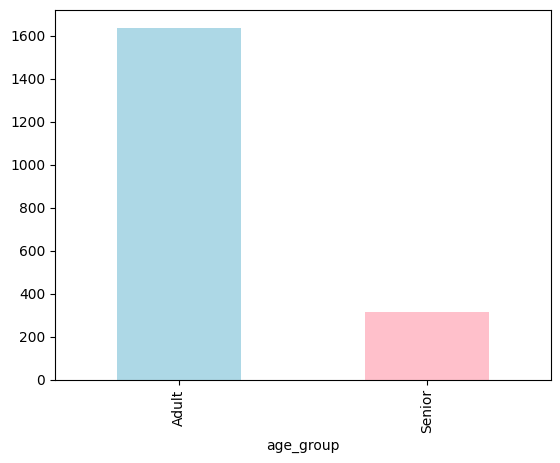

In [236]:
train_df["age_group"].value_counts().plot(kind = "bar", color = ["lightblue", "pink"]);

In [237]:
# Checking null values
train_df.isnull().sum()

SEQN         12
RIDAGEYR      9
RIAGENDR     18
PAQ605       13
BMXBMI       18
LBXGLU       13
DIQ010       18
LBXGLT       11
LBXIN         9
age_group    14
dtype: int64

* catogerical columns = `RIAGENDR`, `DIQ010` - needs to be filled with `mode`
* catogerical column with confusing values = `PAQ605` needs to be filled with `mode` and eleminate confusing values.
* numeric columns = all others remaining - needs to be filled with `mean` values.
* null values needs to be eleminated = `age_group`

In [238]:
# Filling null values

# 1. Filling catogerical column 
train_df["RIAGENDR"].fillna(train_df["RIAGENDR"].mode()[0], inplace=True)
train_df["DIQ010"].fillna(train_df["DIQ010"].mode()[0], inplace=True)

# Replacing confusing values with nan and filling missing values with mode in PAQ605
train_df["PAQ605"] = train_df["PAQ605"].replace({7: np.nan, 9: np.nan})
train_df["PAQ605"].fillna(train_df["PAQ605"].mode()[0], inplace=True)

# Filling remaining numeric missing values with mean of each column 
train_df.fillna(train_df.mean(numeric_only=True), inplace=True)

# Remove rows from age_group with missing values
train_df.dropna(inplace=True)

In [239]:
# Rechecking null values
train_df.isnull().sum()

SEQN         0
RIDAGEYR     0
RIAGENDR     0
PAQ605       0
BMXBMI       0
LBXGLU       0
DIQ010       0
LBXGLT       0
LBXIN        0
age_group    0
dtype: int64

In [240]:
train_df.shape

(1952, 10)

In [241]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1952 entries, 0 to 1965
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       1952 non-null   float64
 1   RIDAGEYR   1952 non-null   float64
 2   RIAGENDR   1952 non-null   float64
 3   PAQ605     1952 non-null   float64
 4   BMXBMI     1952 non-null   float64
 5   LBXGLU     1952 non-null   float64
 6   DIQ010     1952 non-null   float64
 7   LBXGLT     1952 non-null   float64
 8   LBXIN      1952 non-null   float64
 9   age_group  1952 non-null   object 
dtypes: float64(9), object(1)
memory usage: 167.8+ KB


1. Performing EDA on `Test_df`

In [242]:
test_df.head()

,SEQN,RIDAGEYR,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
0,77017.0,34.0,1.0,1.0,32.2,96.0,2.0,135.0,15.11
1,75580.0,12.0,2.0,2.0,26.3,100.0,2.0,141.0,15.26
2,73820.0,56.0,1.0,2.0,28.6,107.0,2.0,136.0,8.82
3,80489.0,20.0,2.0,1.0,22.1,93.0,2.0,111.0,12.13
4,82047.0,64.0,1.0,1.0,24.7,91.0,2.0,105.0,3.12


In [243]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      310 non-null    float64
 1   RIDAGEYR  309 non-null    float64
 2   RIAGENDR  310 non-null    float64
 3   PAQ605    311 non-null    float64
 4   BMXBMI    311 non-null    float64
 5   LBXGLU    311 non-null    float64
 6   DIQ010    311 non-null    float64
 7   LBXGLT    310 non-null    float64
 8   LBXIN     311 non-null    float64
dtypes: float64(9)
memory usage: 22.1 KB


In [244]:
test_df.shape

(312, 9)

In [245]:
test_df.isna().sum()

SEQN        2
RIDAGEYR    3
RIAGENDR    2
PAQ605      1
BMXBMI      1
LBXGLU      1
DIQ010      1
LBXGLT      2
LBXIN       1
dtype: int64

* catogerical columns = `RIAGENDR`, `DIQ010` - needs to be filled with `mode`
* catogerical column with confusing values = `PAQ605` needs to be filled with `mode` and eleminate confusing values.
* numeric columns = all others remaining - needs to be filled with `mean` values.

In [246]:
# Filling null values

# 1. Filling catogerical column 
test_df["RIAGENDR"].fillna(test_df["RIAGENDR"].mode()[0], inplace=True)
test_df["DIQ010"].fillna(test_df["DIQ010"].mode()[0], inplace=True)

# Replacing confusing values with nan and filling missing values with mode in PAQ605
test_df["PAQ605"] = test_df["PAQ605"].replace({7: np.nan, 9: np.nan})
test_df["PAQ605"].fillna(test_df["PAQ605"].mode()[0], inplace=True)

# Filling remaining numeric missing values with mean of each column 
test_df.fillna(test_df.mean(numeric_only=True), inplace=True)

# Remove rows from age_group with missing values
test_df.dropna(inplace=True)

In [247]:
test_df.isna().sum()

SEQN        0
RIDAGEYR    0
RIAGENDR    0
PAQ605      0
BMXBMI      0
LBXGLU      0
DIQ010      0
LBXGLT      0
LBXIN       0
dtype: int64

### 4. Data Preprocessing

In [248]:
# Numerically encoding `age_group` column 

le = LabelEncoder() 
train_df["age_group"] = le.fit_transform(train_df["age_group"])

### 5. Model Building

In [249]:
# Setup random seed
np.random.seed(42)

# Separate feeatures and targets 
x = train_df.drop("age_group", axis=1)
y = train_df["age_group"]

# Splitting data into train, test and validation splits
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y)

In [250]:
# # Feature scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(test_df)

In [251]:
# Instentiate model
clf = RandomForestClassifier(n_estimators=300, random_state=42)
clf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

In [252]:
from sklearn.metrics import f1_score, classification_report

y_val_pred = clf.predict(x_val)
print("F1 Score:", f1_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

F1 Score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       328
           1       1.00      1.00      1.00        63

    accuracy                           1.00       391
   macro avg       1.00      1.00      1.00       391
weighted avg       1.00      1.00      1.00       391



In [253]:
clf_cross_val_score = np.mean(cross_val_score(clf, x, y, cv=5))

In [227]:
clf_cross_val_score

np.float64(0.9994871794871795)

In [254]:
# Make predictions on x_test
test_preds = clf.predict(x_test)

In [257]:
test_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [258]:
# Create DataFrame with just the predictions
submission2 = pd.DataFrame({"age_group": test_preds})

# Save to CSV
submission2.to_csv("submission2.csv", index=False)